In [1]:
import scanpy as sc
import cupy as cp
import pandas as pd
from scipy import stats, linalg
import scipy
import scipy.sparse as sp
import numpy as np
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec
from matplotlib.offsetbox import AnchoredText
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import seaborn as sns

import psutil
import os
import gc

import dask.array as da
from dask import delayed

/home/l202255179/micromamba/envs/sclens/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adata = sc.read_h5ad("../data/aging_mouse_ovary.h5ad")
adata

AnnData object with n_obs × n_vars = 14349 × 20186
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent_ribo', 'percent_hb', 'percent_plat', 'age', 'S.Score', 'G2M.Score', 'Phase', 'pANN_0.25_0.01_763', 'DF.classifications_0.25_0.01_763', 'RNA_snn_res.0.2', 'seurat_clusters', 'cluster.names', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'strain', 'donor_id', 'is_primary_data', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'tissue_type', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'gene_symbols', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_

In [3]:
from scLENS2 import scLENS2
sclens = scLENS2.scLENS2()

preprocessing

In [4]:
sclens._raw = sclens.filtering(adata)
sclens._raw

adata -> sparse
issparse!
Removed 2 cells and 880 genes in QC


<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 43004232 stored elements and shape (14347, 19306)>

In [5]:
filename = sclens._raw.shape[1]
filename 

19306

In [6]:
sclens.X = sclens.normalize(sclens._raw.toarray())
sclens.X = sclens.X.compute()
sclens.X

array([[-1.5414284e-01, -1.5190075e-01,  2.2383224e-02, ...,
        -5.5603519e-02, -3.7486792e-02, -3.6739424e-02],
       [-4.8165910e-02, -4.1722465e-02, -2.7432424e-01, ...,
        -2.7556315e-02, -6.6748848e-03, -4.7566369e-04],
       [-4.6373110e-02, -3.9858595e-02, -2.6724789e-01, ...,
        -2.7081845e-02, -6.1536431e-03,  1.3780594e-04],
       ...,
       [-5.3131633e-02, -4.6885043e-02, -2.9392442e-01, ...,
        -2.8870514e-02, -8.1186267e-03, -2.1748599e-03],
       [-1.5445602e-01, -1.5222636e-01, -6.9386160e-01, ...,
        -5.5686399e-02, -3.7577845e-02, -3.6846589e-02],
       [-1.9392653e-01, -1.9326162e-01, -8.4965557e-01, ...,
        -6.6132419e-02, -4.9053565e-02, -5.0352823e-02]], dtype=float32)

In [ ]:
sclens._raw = sclens._raw.toarray()

print("plotting")
fig1, axs1 = plt.subplots(1, 2, figsize=(10, 5))

axs1[0].hist(np.mean(sclens._raw, axis=1), bins=100)
axs1[1].hist(cp.mean(sclens.X, axis=1), bins=100) 
fig1.suptitle('Mean of Gene Expression along Cells')
fig2, axs2 = plt.subplots(1, 2, figsize=(10, 5))
axs2[0].hist(np.std(sclens._raw, axis=0), bins=100)
axs2[1].hist(cp.std(sclens.X, axis=0), bins=100) 
fig2.suptitle('SD of Gene Expression for each Gene')

RMT

cell x cell matrix
Y_gpu : (14347, 14347)
EVD - GPU
random matix
cell x cell matrix
Y_gpu : (14347, 14347)
EVD - GPU
Max interactions exceeded!
lambda_c: 2.3983905
Number of signal components: 341
L_mp type: <class 'cupy.ndarray'>
L_mp shape: (14003,)


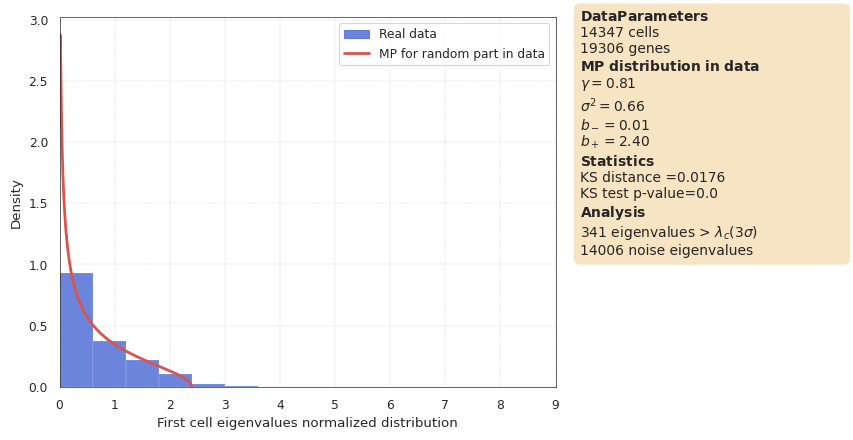

CPU times: user 6min 45s, sys: 19.4 s, total: 7min 4s
Wall time: 1min 23s


In [7]:
%%time
sclens.device = 'gpu'
pca_result = sclens._PCA(sclens.X, device = None, plot_mp = True)

calculate sparsity

In [8]:
bin = sclens._raw
bin.data[:] = 1.
bin

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 43004232 stored elements and shape (14347, 19306)>

In [9]:
bin = bin.toarray()

In [10]:
bin_dask = da.from_array(bin, chunks=(10000, bin.shape[1]))
bin_dask

dask.array<array, shape=(14347, 19306), dtype=float32, chunksize=(10000, 19306), chunktype=numpy.ndarray>

In [12]:
bin_dask.to_zarr(f"./{filename}/file/bin.zarr")

In [13]:
import ctypes

# _raw_ann = sc.read_h5ad("./file/raw_ann.h5ad")
# sclens._raw = _raw_ann.X

sparse = 0.999
shape_row, shape_col = sclens._raw.shape
n_len = shape_row * shape_col
n_zero = n_len - sclens._raw.size

rng = np.random.default_rng()
# Calculate threshold for correlation
n_sampling = min(sclens._raw.shape)
thresh = np.mean([max(np.abs(rng.normal(0, np.sqrt(1/n_sampling), n_sampling)))
                    for _ in range(5000)]).item()
print(f'sparsity_th: {thresh}')

zero_indices_dict = {}
for row in range(shape_row):
    col = sclens._raw[row, :]  # CSR 형식 (1, shape_col)
    zero_indices = np.setdiff1d(np.arange(shape_col), col.indices, assume_unique=True).astype(np.int32)
    if zero_indices.size > 0:
        zero_indices_dict[row] = zero_indices  # 0이 있는 row만 저장
del col, zero_indices
gc.collect()


c_array_pointers = (ctypes.POINTER(ctypes.c_int32) * len(zero_indices_dict))()
for i, key in enumerate(zero_indices_dict):
    c_array_pointers[i] = zero_indices_dict[key].ctypes.data_as(ctypes.POINTER(ctypes.c_int32))

row_sizes = []
for i in range(len(zero_indices_dict)):
    row_sizes.append(len(zero_indices_dict[i]))
row_sizes = np.array(row_sizes, dtype=np.int32)

bin = da.from_zarr(f'./{filename}/file/bin.zarr')

bin_nor = sclens.normalize(bin)
bin_nor = bin_nor.compute()

sclens.device = 'gpu'
Lb, Vb= sclens._PCA_rand(bin_nor, bin.shape[0])
del bin_nor
gc.collect()

n_vbp = Vb.shape[1]//2
n_buffer = 5
buffer = [1] * n_buffer


sparsity_th: 0.034153023206146486
pca - binary matrix
cell x cell matrix
Y_gpu : (14347, 14347)
EVD - GPU


In [14]:
%%time
import zarr

while sparse > sclens.sparsity_threshold:
    n_pert = int((1-sparse) * n_len)
    p = n_pert / n_zero
    rows, cols = sclens._raw.shape
    n_pert, p, rows, cols

    # C 라이브러리 로드
    lib = ctypes.CDLL("./perturb_omp.so")

    # C 함수 프로토타입 설정
    lib.perturb_zeros.argtypes = [
        ctypes.POINTER(ctypes.POINTER(ctypes.c_int)),  # zero_list
        ctypes.POINTER(ctypes.c_int),  # row_sizes
        ctypes.c_int,  # rows
        ctypes.c_double,  # p
        ctypes.POINTER(ctypes.POINTER(ctypes.c_int)),  # output_rows
        ctypes.POINTER(ctypes.c_int),  # output_sizes
    ]

    zero_list_ptr = c_array_pointers
    row_sizes_ptr = row_sizes.ctypes.data_as(ctypes.POINTER(ctypes.c_int))
    output_rows = (ctypes.POINTER(ctypes.c_int) * rows)()
    output_sizes = (ctypes.c_int * rows)()

    print("select noise")
    lib.perturb_zeros(zero_list_ptr, row_sizes_ptr, rows, p, output_rows, output_sizes)

    # 결과를 (row, col) 인덱스로 수집
    row_idx = []
    col_idx = []

    for i in range(rows):
        size = output_sizes[i]
        if size > 0:
            for j in range(size):
                row_idx.append(i)
                col_idx.append(output_rows[i][j])

    data = [1] * len(row_idx)

    pert = sp.coo_matrix((data, (row_idx, col_idx)), shape=(rows, cols))
    pert = pert.tocsr()

    bin_sparse = sclens._raw
    bin_sparse.data[:] = 1.

    print("perturbation matrix")
    shape = pert.shape
    block_size = 10000

    # Zarr로 저장 (dense로)
    zarr_path = f"./{filename}/file/perturbed.zarr"
    zarr_out = zarr.open(zarr_path, mode="w", shape=shape, dtype=np.float32, chunks=(block_size, shape[1]))

    for i in range(0, shape[0], block_size):
        end = min(i + block_size, shape[0])
        block = (pert[i:end] + bin_sparse[i:end]).toarray()
        zarr_out[i:end] = block

    pert = da.from_zarr(f"./{filename}/file/perturbed.zarr")

    print('normalization - perturb')
    pert = sclens.normalize(pert).compute()

    Lbp, Vbp = sclens._PCA_rand(pert, n_vbp)
    del pert
    gc.collect()

    corr_arr = cp.max(cp.abs(Vb.T @ Vbp), axis=0).get()
    corr = np.sort(corr_arr)[1]
    buffer.pop(0)
    buffer.append(corr)
    print(f'Min(corr): {corr}, sparsity: {sparse}')
    if all([x < thresh for x in buffer]):
        sclens.sparsity = sparse + sclens.sparsity_step * (n_buffer - 1)
        break
    sparse -= sclens.sparsity_step

select noise
perturbation matrix
normalization - perturb
pca - binary matrix
cell x cell matrix
Y_gpu : (14347, 14347)
EVD - GPU
Min(corr): 0.043215543031692505, sparsity: 0.999
select noise
perturbation matrix
normalization - perturb
pca - binary matrix
cell x cell matrix
Y_gpu : (14347, 14347)
EVD - GPU
Min(corr): 0.03850751742720604, sparsity: 0.998
select noise
perturbation matrix
normalization - perturb
pca - binary matrix
cell x cell matrix
Y_gpu : (14347, 14347)
EVD - GPU
Min(corr): 0.03672622889280319, sparsity: 0.997
select noise
perturbation matrix
normalization - perturb
pca - binary matrix
cell x cell matrix
Y_gpu : (14347, 14347)
EVD - GPU
Min(corr): 0.03579917550086975, sparsity: 0.996
select noise
perturbation matrix
normalization - perturb
pca - binary matrix
cell x cell matrix
Y_gpu : (14347, 14347)
EVD - GPU
Min(corr): 0.034910060465335846, sparsity: 0.995
select noise
perturbation matrix
normalization - perturb
pca - binary matrix
cell x cell matrix
Y_gpu : (14347, 1

In [15]:
sclens.sparsity

0.994

In [16]:
sclens._signal_components = pca_result[1]

In [17]:
%%time
import zarr

sclens.device = 'gpu'
pert_vecs = list()
for _ in tqdm(range(sclens.n_rand_matrix), total=sclens.n_rand_matrix):
    rand = scipy.sparse.rand(sclens._raw.shape[0], sclens._raw.shape[1], 
                                    density=1-sclens.sparsity, 
                                    format='csr')
    rand.data[:] = 1

    block_size = 10000
    shape = rand.shape
    rand_zarr_path = f"./{filename}/file/srt_perturbed.zarr"
    zarr_out = zarr.open(rand_zarr_path, mode="w", shape=shape, dtype=np.float32, chunks=(block_size, shape[1]))

    for i in range(0, shape[0], block_size):
        end = min(i + block_size, shape[0])
        block = (rand[i:end] + sclens._raw[i:end]).toarray()
        zarr_out[i:end] = block

    rand = da.from_zarr(f"./{filename}/file/srt_perturbed.zarr")
    rand = sclens._preprocess_rand(rand)
    
    n = min(sclens._signal_components.shape[1] * sclens._perturbed_n_scale, sclens.X.shape[1])

    if sclens.device == 'cpu':
        pass
    elif sclens.device == 'gpu':
        perturbed_L, perturbed_V = sclens._PCA_rand(rand, n)
        perturbed = cp.asarray(perturbed_V)
    
    print('perturbed:', perturbed.shape)

    pert_select = sclens._signal_components.T @ perturbed
    pert_select = cp.abs(pert_select)
    pert_select = cp.argmax(pert_select, axis = 1)
    pert_vecs.append(perturbed[:, pert_select])

    del rand, perturbed, pert_select
    gc.collect()
    cp.get_default_memory_pool().free_all_blocks()
    cp.get_default_pinned_memory_pool().free_all_blocks()


  0%|          | 0/20 [00:00<?, ?it/s]

pca - binary matrix
cell x cell matrix
Y_gpu : (14347, 14347)
EVD - GPU
perturbed: (14347, 682)


  5%|▌         | 1/20 [00:51<16:21, 51.65s/it]

pca - binary matrix
cell x cell matrix
Y_gpu : (14347, 14347)
EVD - GPU
perturbed: (14347, 682)


 10%|█         | 2/20 [01:27<12:45, 42.53s/it]

pca - binary matrix
cell x cell matrix
Y_gpu : (14347, 14347)
EVD - GPU
perturbed: (14347, 682)


 15%|█▌        | 3/20 [02:19<13:13, 46.70s/it]

pca - binary matrix
cell x cell matrix
Y_gpu : (14347, 14347)
EVD - GPU
perturbed: (14347, 682)


 20%|██        | 4/20 [02:55<11:21, 42.60s/it]

pca - binary matrix
cell x cell matrix
Y_gpu : (14347, 14347)
EVD - GPU
perturbed: (14347, 682)


 25%|██▌       | 5/20 [03:46<11:23, 45.58s/it]

pca - binary matrix
cell x cell matrix
Y_gpu : (14347, 14347)
EVD - GPU
perturbed: (14347, 682)


 30%|███       | 6/20 [04:22<09:53, 42.39s/it]

pca - binary matrix
cell x cell matrix
Y_gpu : (14347, 14347)
EVD - GPU
perturbed: (14347, 682)


 35%|███▌      | 7/20 [05:13<09:45, 45.03s/it]

pca - binary matrix
cell x cell matrix
Y_gpu : (14347, 14347)
EVD - GPU
perturbed: (14347, 682)


 40%|████      | 8/20 [05:49<08:26, 42.22s/it]

pca - binary matrix
cell x cell matrix
Y_gpu : (14347, 14347)
EVD - GPU
perturbed: (14347, 682)


 45%|████▌     | 9/20 [06:38<08:09, 44.48s/it]

pca - binary matrix
cell x cell matrix
Y_gpu : (14347, 14347)
EVD - GPU
perturbed: (14347, 682)


 50%|█████     | 10/20 [07:15<07:00, 42.00s/it]

pca - binary matrix
cell x cell matrix
Y_gpu : (14347, 14347)
EVD - GPU
perturbed: (14347, 682)


 55%|█████▌    | 11/20 [08:01<06:29, 43.24s/it]

pca - binary matrix
cell x cell matrix
Y_gpu : (14347, 14347)
EVD - GPU
perturbed: (14347, 682)


 60%|██████    | 12/20 [08:41<05:37, 42.15s/it]

pca - binary matrix
cell x cell matrix
Y_gpu : (14347, 14347)
EVD - GPU
perturbed: (14347, 682)


 65%|██████▌   | 13/20 [09:21<04:50, 41.54s/it]

pca - binary matrix
cell x cell matrix
Y_gpu : (14347, 14347)
EVD - GPU
perturbed: (14347, 682)


 70%|███████   | 14/20 [10:05<04:14, 42.47s/it]

pca - binary matrix
cell x cell matrix
Y_gpu : (14347, 14347)
EVD - GPU
perturbed: (14347, 682)


 75%|███████▌  | 15/20 [10:42<03:23, 40.73s/it]

pca - binary matrix
cell x cell matrix
Y_gpu : (14347, 14347)
EVD - GPU
perturbed: (14347, 682)


 80%|████████  | 16/20 [11:38<03:01, 45.31s/it]

pca - binary matrix
cell x cell matrix
Y_gpu : (14347, 14347)
EVD - GPU
perturbed: (14347, 682)


 85%|████████▌ | 17/20 [12:16<02:09, 43.21s/it]

pca - binary matrix
cell x cell matrix
Y_gpu : (14347, 14347)
EVD - GPU
perturbed: (14347, 682)


 90%|█████████ | 18/20 [12:52<01:22, 41.06s/it]

pca - binary matrix
cell x cell matrix
Y_gpu : (14347, 14347)
EVD - GPU


 95%|█████████▌| 19/20 [13:30<00:39, 39.96s/it]

perturbed: (14347, 682)
pca - binary matrix
cell x cell matrix
Y_gpu : (14347, 14347)
EVD - GPU
perturbed: (14347, 682)


100%|██████████| 20/20 [14:13<00:00, 42.67s/it]

CPU times: user 1h 5s, sys: 5min 40s, total: 1h 5min 46s
Wall time: 14min 13s


In [18]:
pert_scores = list()
for i in range(sclens.n_rand_matrix):
    for j in range(i+1, sclens.n_rand_matrix):
        dots = pert_vecs[i].T @ pert_vecs[j]
        corr = cp.max(cp.abs(dots), axis = 1)
        pert_scores.append(corr.get())

In [19]:
pert_scores

[array([0.15731211, 0.2238232 , 0.12929328, 0.0962289 , 0.20214874,
        0.17145266, 0.08275203, 0.12789597, 0.11918214, 0.11688109,
        0.09045966, 0.09522801, 0.15482877, 0.10951109, 0.14543948,
        0.17145266, 0.0778456 , 0.05234323, 0.0533317 , 0.08263104,
        0.15462062, 0.20921677, 0.18796599, 0.14123426, 0.1613747 ,
        0.08973997, 0.3645209 , 0.13696393, 0.2867961 , 0.1653771 ,
        0.12474051, 0.113602  , 0.08567565, 0.14543948, 0.07548167,
        0.12601903, 0.15697163, 0.1035806 , 0.13543421, 0.10296532,
        0.08462407, 0.27446926, 0.09026688, 0.08584323, 0.15390608,
        0.07881576, 0.22876729, 0.22876729, 0.11711348, 0.12539771,
        0.06079981, 0.05629867, 0.11130961, 0.14543948, 0.20214874,
        0.15731211, 0.140687  , 0.3645209 , 0.09921619, 0.11784032,
        0.10135017, 0.17224413, 0.17224413, 0.14572552, 0.08263104,
        0.15390608, 0.15390608, 0.12601903, 0.05553205, 0.2019915 ,
        0.12181474, 0.09045966, 0.1772415 , 0.26

In [20]:
th_rad = np.deg2rad(60)
sclens.threshold = np.cos(th_rad)
sclens.threshold

np.float64(0.5000000000000001)

In [21]:
pert_scores = cp.array(pert_scores)
type(pert_scores)

cupy.ndarray

In [22]:
def iqr(x):
    q1 = cp.percentile(x, 25)
    q3 = cp.percentile(x, 75)
    iqr = q3 - q1
    filtered = x[(x >= q1 -1.5*iqr) & (x <= q3 + 1.5*iqr)]
    return cp.median(filtered)

rob_scores = cp.array([iqr(pert_scores[:,i]) for i in range(pert_scores.shape[1])])
rob_scores   


array([0.1238604 , 0.12347171, 0.11712655, 0.11116407, 0.11516558,
       0.09487312, 0.10565063, 0.11205635, 0.10316089, 0.11759697,
       0.1014666 , 0.10445385, 0.12247416, 0.10951109, 0.11756377,
       0.11529259, 0.10753284, 0.1139491 , 0.14398181, 0.11369305,
       0.13808557, 0.09357793, 0.12508585, 0.1298157 , 0.12759666,
       0.1065608 , 0.13748325, 0.09472084, 0.14121579, 0.12167339,
       0.12857991, 0.11254914, 0.1224447 , 0.13106161, 0.11016519,
       0.12284002, 0.1690462 , 0.11174403, 0.11906426, 0.12496406,
       0.10473397, 0.12700222, 0.10363179, 0.11964983, 0.12161803,
       0.11443773, 0.1225979 , 0.1251277 , 0.11708729, 0.13230117,
       0.11189702, 0.11095871, 0.1056771 , 0.12494104, 0.13004592,
       0.13889962, 0.12293161, 0.11912963, 0.13020204, 0.17438322,
       0.12058436, 0.12758829, 0.12633795, 0.11453559, 0.1175019 ,
       0.1222405 , 0.12813179, 0.1533803 , 0.13109505, 0.13555244,
       0.12340102, 0.11015488, 0.12133664, 0.1282275 , 0.13015

In [23]:
robust_idx = rob_scores > sclens.threshold
robust_idx

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [24]:
sclens._robust_idx = robust_idx
sclens.X_transform = pca_result[1][:, sclens._robust_idx] * cp.sqrt(pca_result[0][sclens._robust_idx]).reshape(1, -1)
sclens.robust_scores = pert_scores

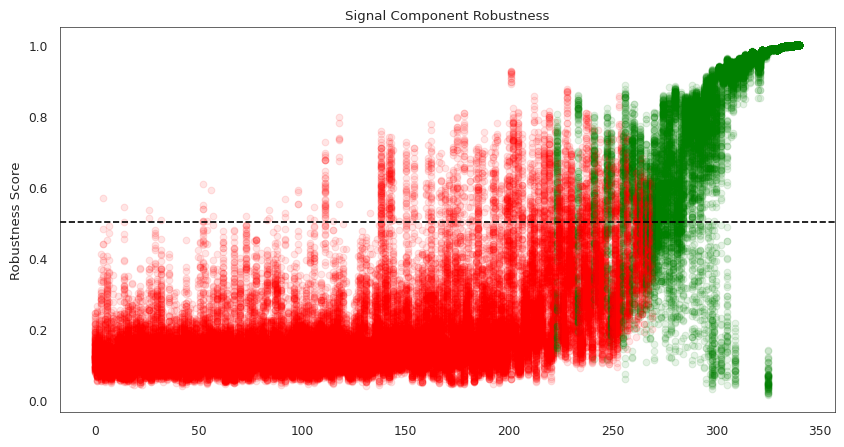

In [31]:
sclens.plot_robust_score()

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_robust_score():
    m_scores = sclens.robust_scores.mean(axis=0).get()  # mean stability per component
    sd_scores = sclens.robust_scores.std(axis=0).get()   # std deviation per component
    nPC = np.arange(1, len(m_scores)+1)

    # colormap (inverse of m_scores like Julia code: 1 - m_scores)
    colors = cm.get_cmap("RdBu")(1.0 - m_scores)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_xlabel("nPC")
    ax.set_ylabel("Stability")
    ax.set_title(f"{np.sum(sclens._robust_idx)} robust signals were detected")

    # Scatter plot with color encoding
    ax.scatter(nPC, m_scores, c=colors, s=50, edgecolor='k')  # size ~ markersize=10 in Julia
    ax.errorbar(nPC, m_scores, yerr=sd_scores, fmt='none', color='gray', capsize=4, linewidth=1)

    ax.axhline(y=sclens.threshold, color='k', linestyle='--')  # threshold line



/tmp/ipykernel_27419/2114791751.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("RdBu")(1.0 - m_scores)


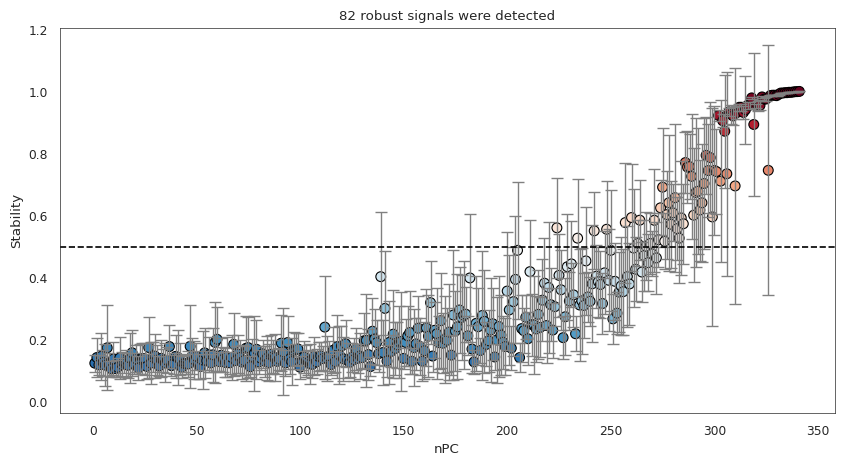

In [34]:
plot_robust_score()